In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
46743,chr16,223472,223709,unfragmented.rvs_peak_9830,22989,593.97974,2306.09131,2298.91455,775.0,15,.,Unannotated,-,LSM11,RBP,0.0,0.0,Antisense
46744,chr16,230338,230554,unfragmented.rvs_peak_9833,19003,478.41898,1907.42175,1900.30774,690.0,12,.,Unannotated,-,NCBP2,RBP,0.0,0.0,Antisense
46742,chr10,71355030,71355103,unfragmented.rvs_peak_3389,28895,674.90723,2897.06421,2889.54199,684.0,14,.,Unannotated,-,.,Unannotated,0.0,0.0,Unannotated
46745,chr16,227336,227447,unfragmented.rvs_peak_9832,18507,478.65143,1857.76416,1850.75354,661.0,12,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
0,chr11,65273309,65273587,unfragmented.fwd_peak_5292,21282,509.75793,2135.26367,2128.24292,516.0,15,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense


In [3]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/home/cdw2854/cfNA/plots/peak_utils.py:483: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 1e4)


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


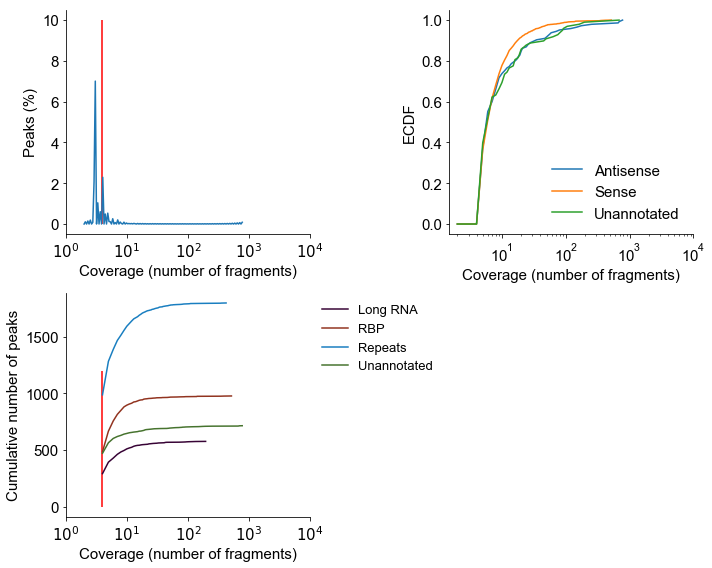

In [4]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [5]:
peak_df.sense_gtype.unique()

array(['Unannotated', 'RBP', 'Repeats', 'Long RNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


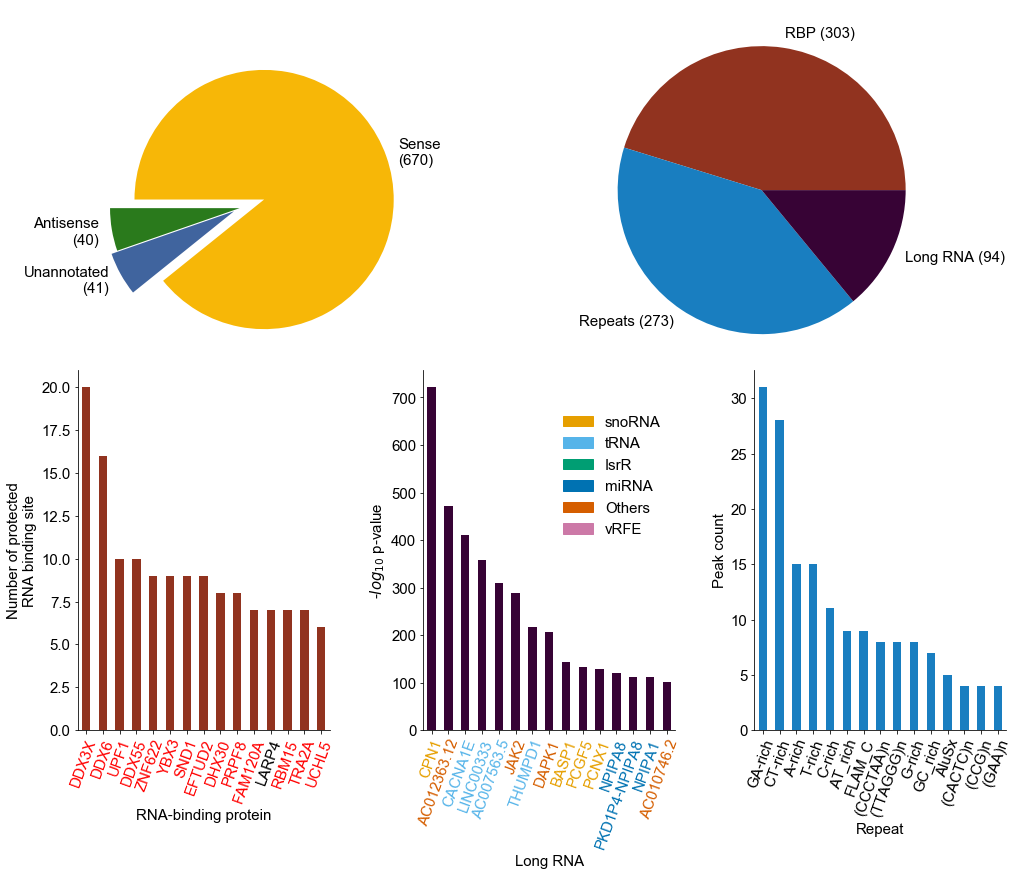

In [7]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
#l1 = mlines.Line2D([0.3,0.6],[0.9,0.955], color= 'black',
#                   figure = fig,  transform=fig.transFigure)
#l2 = mlines.Line2D([0.3,0.65],[0.58,0.51], color= 'black',
#                   figure = fig,  transform=fig.transFigure)
#fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [159]:
import RNA 

lr_peak = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)

In [160]:
cmscan_df = read_tbl(peak_path + '/unfragmented.Long_RNA.tblout') \
    .assign(peakname = lambda d: d['query name'].str.split('(', expand=True).iloc[:,0]\
                                   .str.replace('^RF[0-9]+','')\
                                   .str.strip(' '))\
    .assign(strand = lambda d: np.where(d.strand=="+", 0,1) )\
    .groupby('peakname', as_index=False)\
    .apply(lambda d: d.pipe(lambda d1: d1[d1.strand==d1.strand.min()]).pipe(lambda d1: d1[d1.score==d1.score.max()]))
cmscan_df.head()

,,E-value,accession,bias,description of target,gc,inc,mdl,mdl from,mdl to,pass,query name,score,seq from,seq to,strand,target name,trunc,peakname
0,40,1 0.78,) -,6 0.3,-,1 0.66,8 ?,cm,m 1,1 106,o 1,unfragmented.fwd_peak_10809(+),3 14.1,6 3,3 106,1,mir-1249,+ no,unfragmented.fwd_peak_10809
1,38,6 4.2,) -,6 0.7,-,1 0.66,2 ?,cm,m 1,1 106,o 1,unfragmented.fwd_peak_10827(+),7 11.6,6 3,3 106,1,mir-1249,+ no,unfragmented.fwd_peak_10827
2,298,1.6,-,0.0,-,0.42,?,cm,1,84,1,unfragmented.fwd_peak_1162(+),17.7,15,95,0,SNORD19B,no,unfragmented.fwd_peak_1162
3,79,4 4,) -,2 0.0,-,1 0.52,4 ?,cm,m 1,1 147,o 1,unfragmented.fwd_peak_12214(+),0 10.4,7 128,8 20,1,ACAT,- no,unfragmented.fwd_peak_12214
4,205,5 7.4,) -,3 0.0,-,1 0.53,4 ?,cm,m 1,1 23,o 1,unfragmented.fwd_peak_13957(+),0 11.5,3 46,6 81,1,UPSK,+ no,unfragmented.fwd_peak_13957


In [161]:
cmscan_df.reset_index().filter(regex='name')

,query name,target name,peakname
0,unfragmented.fwd_peak_10809(+),mir-1249,unfragmented.fwd_peak_10809
1,unfragmented.fwd_peak_10827(+),mir-1249,unfragmented.fwd_peak_10827
2,unfragmented.fwd_peak_1162(+),SNORD19B,unfragmented.fwd_peak_1162
3,unfragmented.fwd_peak_12214(+),ACAT,unfragmented.fwd_peak_12214
4,unfragmented.fwd_peak_13957(+),UPSK,unfragmented.fwd_peak_13957
5,unfragmented.fwd_peak_14146(+),snoTBR5,unfragmented.fwd_peak_14146
6,unfragmented.fwd_peak_14345(+),mir-615,unfragmented.fwd_peak_14345
7,unfragmented.fwd_peak_15691(+),PYLIS_3,unfragmented.fwd_peak_15691
8,unfragmented.fwd_peak_16492(+),HSUR,unfragmented.fwd_peak_16492
9,unfragmented.fwd_peak_17333(+),mir-302,unfragmented.fwd_peak_17333


In [162]:
lr_peak.merge(cmscan_df, on ='peakname', how='left')\
    .filter(['chrom','start','end', 'peakname','log10p', 'sense_gname','target name','strand_x'])\
    .nlargest(15,'log10p')

,chrom,start,end,peakname,log10p,sense_gname,target name,strand_x
0,chr10,101817586,101817662,unfragmented.rvs_peak_3743,721.39008,CPN1,TtnuHACA22,-
1,chr2,120972694,120972773,unfragmented.fwd_peak_16492,471.60416,AC012363.12,HSUR,+
2,chr1,181391983,181392122,unfragmented.fwd_peak_2182,410.02588,CACNA1E,tRNA,+
3,chr13,85095787,85095865,unfragmented.fwd_peak_8192,358.15884,LINC00333,tRNA,+
4,chr2,217744485,217744561,unfragmented.fwd_peak_17347,309.29858,AC007563.5,tRNA,+
5,chr9,5095156,5095228,unfragmented.fwd_peak_29842,287.60461,JAK2,NaN,+
6,chr16,20733605,20733724,unfragmented.rvs_peak_10165,216.16002,THUMPD1,tRNA,-
7,chr9,90294212,90294292,unfragmented.fwd_peak_30370,205.93515,DAPK1,CRISPR-DR15,+
8,chr5,17249702,17249764,unfragmented.fwd_peak_23386,142.73158,BASP1,snoR117,+
9,chr10,92933895,92933969,unfragmented.fwd_peak_3946,132.22964,PCGF5,snoU25,+


In [163]:
lr_peak.query('width == 1751')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width


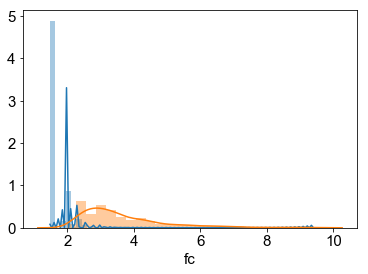

In [164]:
sns.distplot(peak_df.fc.transform(np.log2))
sns.distplot(peak_df.query('pileup >= 4 & sample_count >= 5').fc.transform(np.log2))

In [165]:
lr_peak.query('peakname=="unfragmented.fwd_peak_28467"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width


In [166]:
fold = lr_peak.nlargest(20,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
7,chr10,101817586,101817662,unfragmented.rvs_peak_3743,7149,193.04219,721.39008,714.94635,195.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
10,chr2,120972694,120972773,unfragmented.fwd_peak_16492,4652,133.66429,471.60416,465.27069,135.0,14,...,AC012363.4,Long RNA,0.000000e+00,0.000000e+00,Sense,ACTTTTAAAGAATTAGAGTTGTCTATTGGTCTTAGGAACCAAAAAC...,not_MT,(((((((........(((((((((((((((.......))))).......,-13.000000,79
13,chr1,181391983,181392122,unfragmented.fwd_peak_2182,4038,117.11033,410.02588,403.81241,118.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,CGAGAAAGTGTACAAGAACTGCTAACTCATGCCCCCATGCCTAGCA...,not_MT,.((((((((...((.(...(((((...((((....))))..)))))...,-26.600000,139
14,chr13,85095787,85095865,unfragmented.fwd_peak_8192,3520,102.54318,358.15884,352.01163,103.0,14,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAATTTTTAAAGGATAAGACTTATCTGTTGGTCTTAGGAACCCAAA...,not_MT,..(((((((..((((((((((........)))))))((...))......,-8.700000,78
20,chr2,217744485,217744561,unfragmented.fwd_peak_17347,3032,93.94147,309.29858,303.20868,95.0,15,...,.,Unannotated,5.028286e-310,9.807987e-307,Sense,AACTTTTAAATAATAGAAGTAATACATTGGCCTTAAAAGCCAAGAA...,not_MT,.(((((((.....)))))))......(((((.......)))))......,-10.700000,76


In [167]:
import random
from collections import Counter
from scipy.stats import ranksums

es = []
bases = list('ACTG')
for w, seq in zip(fold.width, fold.seq):
    b = Counter(seq.upper())
    weights = [b[n] for n in bases]
    for i in range(20):
        random_seq = ''.join(random.choices(list('ACTG'), 
                                            k=w, weights=weights))
        s, e = RNA.fold(random_seq)
        es.append(e)

In [168]:
w, p = ranksums(es, fold.energy.values)

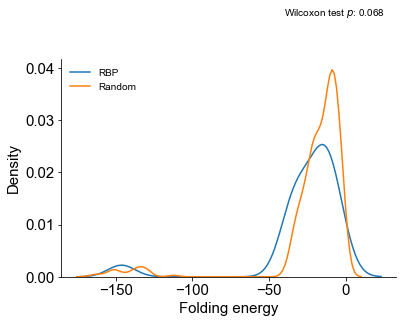

In [169]:
ax = plt.subplot()
sns.distplot(fold.energy, label = 'RBP', ax = ax, hist=False)
sns.distplot(es, label = 'Random', ax = ax, hist=False)
ax.text(-40,0.05, 'Wilcoxon test $p$: %.3f' %p)
ax.legend(frameon=False)
sns.despine()
ax.set_xlabel('Folding energy')
ax.set_ylabel('Density')
plt.savefig(figure_path + '/fold_energy.pdf', bbox_inches='tight')

# Intron #

In [191]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(111, 24)

In [192]:
intron_df \
    .query('pileup >= 5 & sample_count > 5' )\
    .filter(['chrom','start','end','peakname','sense_gname'])\
    .drop_duplicates()

,chrom,start,end,peakname,sense_gname
0,chr19,11333582,11333668,unfragmented.rvs_peak_13218,EFTUD2
1,chr17,39913789,39913885,unfragmented.rvs_peak_11524,XPO5
2,chr16,18430618,18430707,unfragmented.rvs_peak_10130,RP11-1212A22.1
3,chr16,15027134,15027223,unfragmented.fwd_peak_10809,RP11-958N24.1
4,chr16,2149772,2149861,unfragmented.rvs_peak_9905,EFTUD2
5,chr15,91423005,91423096,unfragmented.fwd_peak_10391,XPO5
6,chr16,18470720,18470809,unfragmented.rvs_peak_10132,RP11-1212A22.4
7,chr17,73500562,73500652,unfragmented.rvs_peak_11963,CASKIN2
8,chr17,48216682,48216793,unfragmented.rvs_peak_11667,PRPF8
9,chr3,52265012,52265142,unfragmented.rvs_peak_18928,SF3A3


In [188]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []       

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,seq,dinucleotide
0,chr19,11333582,11333668,unfragmented.rvs_peak_13218,14263,378.40411,1433.17261,1426.35217,389.0,15,...,0.000000e+00,Sense,chr19,11333582,11333668,ENSG00000130158.9,0,-,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:CA
1,chr17,39913789,39913885,unfragmented.rvs_peak_11524,1307,45.94406,136.43619,130.72487,46.0,15,...,3.175319e-134,Sense,chr17,39913789,39913885,ENSG00000173801.12,0,-,GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCAC...,GT:CA
2,chr16,18430618,18430707,unfragmented.rvs_peak_10130,1144,42.62552,120.06575,114.40904,43.0,14,...,6.623306e-118,Sense,chr16,18430618,18430707,ENSG00000214940.4,0,-,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:CA
3,chr16,15027134,15027223,unfragmented.fwd_peak_10809,1062,41.25366,111.85247,106.20515,42.0,13,...,1.031385e-109,Sense,chr16,15027134,15027223,ENSG00000183426.11,0,+,TGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTCC...,TG:AG
4,chr16,2149772,2149861,unfragmented.rvs_peak_9905,973,36.91322,102.91055,97.31214,37.0,12,...,8.427882e-101,Sense,chr16,2149772,2149861,ENSG00000008710.13,0,-,GTGGGTGCCGTAGGGGTCGGGGCAGCCTCTTCCTGCCCAGCCCTTC...,GT:CA


In [189]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/intron_table.csv


In [190]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

,start,end,score,fc,log10p,log10q,pileup,sample_count,pvalue,FDR,intron_start,intron_end,intron_score,length
count,5.300000e+01,5.300000e+01,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,5.300000e+01,5.300000e+01,5.300000e+01,5.300000e+01,53.0,53.000000
mean,4.946649e+07,4.946659e+07,498.830189,18.333831,54.673510,49.932034,17.886792,5.603774,2.037014e-10,2.206619e-09,4.946648e+07,4.946659e+07,0.0,101.264151
std,4.717703e+07,4.717704e+07,1951.034812,51.503806,195.454301,195.102682,53.083628,3.665534,6.572705e-10,6.116219e-09,4.717703e+07,4.717704e+07,0.0,24.110444
min,7.817520e+05,7.818930e+05,45.000000,4.750940,8.500520,4.578490,4.000000,1.000000,0.000000e+00,0.000000e+00,7.817510e+05,7.819270e+05,0.0,68.000000
25%,1.133358e+07,1.133367e+07,61.000000,4.895890,10.448500,6.185290,4.000000,3.000000,5.370318e-33,1.057427e-30,1.133358e+07,1.133367e+07,0.0,86.000000
50%,4.704579e+07,4.704587e+07,104.000000,6.837900,15.087460,10.439420,6.000000,4.000000,8.175983e-16,4.945044e-14,4.704579e+07,4.704587e+07,0.0,90.000000
75%,6.706862e+07,6.706875e+07,271.000000,12.761450,32.270000,27.191980,12.000000,7.000000,3.560410e-11,7.356295e-10,6.706862e+07,6.706875e+07,0.0,124.000000
max,1.840983e+08,1.840984e+08,14263.000000,378.404110,1433.172610,1426.352170,389.000000,15.000000,3.158494e-09,2.700642e-08,1.840983e+08,1.840984e+08,0.0,182.000000


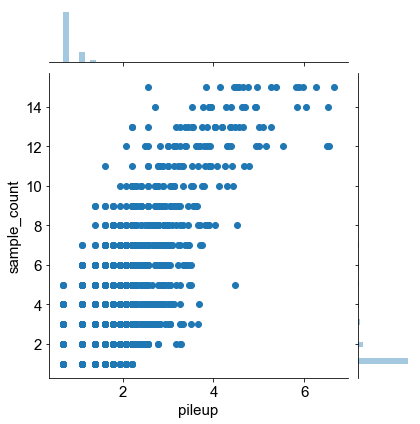

In [178]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [179]:
','.join(rbp_df.head(15).index)

'DDX3X,DDX6,UPF1,DDX55,ZNF622,YBX3,SND1,EFTUD2,DHX30,PRPF8,FAM120A,LARP4,RBM15,TRA2A,UCHL5'

In [180]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

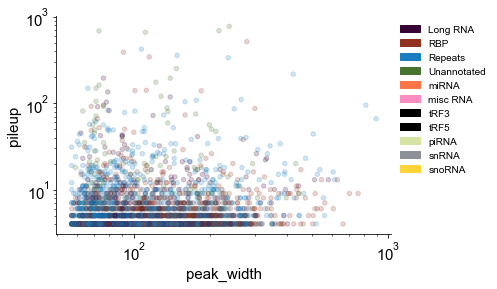

In [181]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

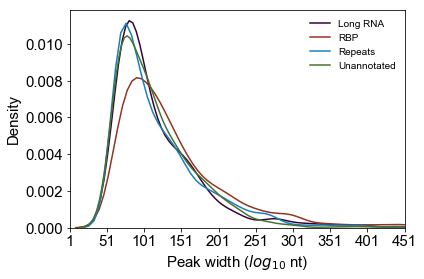

In [182]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [183]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
7,chr10,101817586,101817662,unfragmented.rvs_peak_3743,7149,193.04219,721.39008,714.94635,195.0,15,CPN1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
10,chr2,120972694,120972773,unfragmented.fwd_peak_16492,4652,133.66429,471.60416,465.27069,135.0,14,AC012363.12,Long RNA,+,AC012363.4,Long RNA,0.000000e+00,0.000000e+00,Sense
13,chr1,181391983,181392122,unfragmented.fwd_peak_2182,4038,117.11033,410.02588,403.81241,118.0,15,CACNA1E,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
14,chr13,85095787,85095865,unfragmented.fwd_peak_8192,3520,102.54318,358.15884,352.01163,103.0,14,LINC00333,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
20,chr2,217744485,217744561,unfragmented.fwd_peak_17347,3032,93.94147,309.29858,303.20868,95.0,15,AC007563.5,Long RNA,+,.,Unannotated,5.028286e-310,9.807987e-307,Sense
21,chr9,5095156,5095228,unfragmented.fwd_peak_29842,2815,89.65012,287.60461,281.55255,91.0,15,JAK2,Long RNA,+,.,Unannotated,2.485364e-288,4.562690e-285,Sense
29,chr16,20733605,20733724,unfragmented.rvs_peak_10165,2102,70.82949,216.16002,210.24493,72.0,14,THUMPD1,Long RNA,-,SFPQ,RBP,6.917991e-217,9.595715e-214,Sense
32,chr9,90294212,90294292,unfragmented.fwd_peak_30370,2000,75.12357,205.93515,200.01402,82.0,11,DAPK1,Long RNA,+,.,Unannotated,1.161048e-206,1.509797e-203,Sense
45,chr5,17249702,17249764,unfragmented.fwd_peak_23386,1369,45.35564,142.73158,136.96867,45.0,8,BASP1,Long RNA,+,.,Unannotated,1.855325e-143,1.678343e-140,Sense
51,chr10,92933895,92933969,unfragmented.fwd_peak_3946,1265,42.39766,132.22964,126.50797,42.0,10,PCGF5,Long RNA,+,.,Unannotated,5.893320e-133,4.840121e-130,Sense


In [184]:
anti_peaks.antisense_gtype.unique()

NameError: name 'anti_peaks' is not defined

In [ ]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d